# TDT17 2022-P3-T2-ST1 task

Shared attention is a concept used in the [MulT architecture](https://openaccess.thecvf.com/content/CVPR2022/papers/Bhattacharjee_MulT_An_End-to-End_Multitask_Learning_Transformer_CVPR_2022_paper.pdf) in order for a multi-task network to learn between-task dependencies. In MulT, all tasks share the same encoders, while deploying task-specific decoders. The shared attention blocks are introduced in each decoder block, and this task will have you calculate the outputs for a shared attention block on an input that has been simplified to suit the time constraint of the TDT17 tasks format. The goal of this task is not to interpret how the output is affected by a specific inputs (especially since the linear layers are stochastically generated here), but instead to gain an insight in what separates shared attention from self-attetion. A single task *t* is considered, with an additional reference task *r*. The details of what these tasks are is not important.

## Given:
* The shared attention block from MulT  
    ![shared-attention](shared-attention.png)
* A skip connection $x_{s}$ from the shared encoder
* The upsampled output $x^t$ from the previous decoder stage
* The upsampled output $x^r$ from the previous decoder stage of some "reference" task
* M = 6 attention heads
* Helper functions to generate matrices and vectors

## Find:
* The dimensions for the projections in each attention head
* The dimensions for the projections of the multi-head attention output
* The outputs $y^t$ and $y^r$ of the shared attention block
* Answer: Which modifications have been made vs. "standard" self-attention?
* Answer: Where does the shared attention block utilize information from other tasks?

Note: Wherever a learnable parameter is used in MulT, it is fine simply replacing it with something randomly generated :)

# Helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x, axis=0):
    return np.exp(x) / np.sum(np.exp(x), axis=axis)

def normalize(x):
    """
    Normalize a 1D vector
    """
    return (x - x.mean()) / x.std() 

def linear(n, m):
    """
    Generate an nxm array of normally distributed values
    """
    return np.random.normal(0, 1, n * m).reshape((n, m))

def x(n):
    """
    Generate a nx1 vector of normally distributed values.
    """
    return np.random.normal(0, 1, n).reshape((n, 1))


def draw(data, title: str = "") -> None:
        """Display a visualization of the matrix values

        See: https://stackoverflow.com/questions/40887753/display-matrix-values-and-colormap

        Assumes data on the form nx1 where n is a perfect square number
        """
        fig, ax = plt.subplots()
        
        n = int(np.sqrt(data.shape[0]))
        data = data.reshape((n, n))

        ax.matshow(data, cmap=plt.cm.Blues)
        ax.set_title(title)

        for col, row in np.ndindex(data.shape):
            ax.text(col, row, f"{data[row, col]:.2f}", va='center', ha='center')


# Given variables

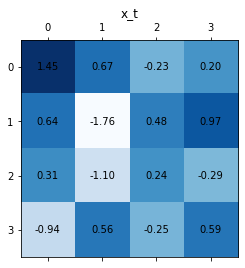

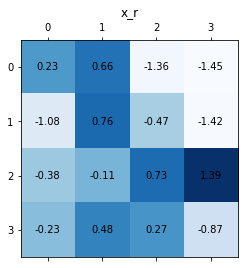

In [2]:
M = 6

H = 4
W = 4

ndim = H * W

x_t = x(ndim)
x_s = x(ndim)
x_r = x(ndim)

Cr = 1 # Number of channels

draw(x_t, "x_t")
draw(x_r, "x_r")

# Solution

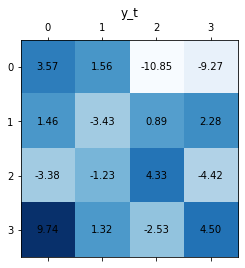

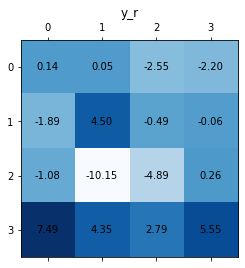

In [3]:

X_t = np.empty((ndim, M))
X_r = np.empty((ndim, M))

x_s = normalize(x_s)
x_r = normalize(x_r)
x_t = normalize(x_t)

for head_i in range(M):
    W_qk = linear(ndim, ndim)
    W_vr = linear(ndim, ndim)
    W_vt = linear(ndim, ndim)

    q_sa = k_sa = W_qk @ x_s
    v_r = W_vr @ x_r
    v_t = W_vt @ x_t

    A_sa = softmax((q_sa @ k_sa.T) / np.sqrt(Cr) + np.random.uniform(0, 1))

    x_r_i = A_sa @ v_r
    x_t_i = A_sa @ v_t

    X_r[:, head_i] = x_r_i.ravel()
    X_t[:, head_i] = x_t_i.ravel()

W_r = linear(M, 1)
W_t = linear(M, 1)

x_r_linear = X_r @ W_r
x_t_linear = X_t @ W_t

y_r = x_r_linear + x_r
y_t = x_t_linear + x_t

draw(y_t, "y_t")
draw(y_r, "y_r")

# Questions
1. Which modifications have been made vs. "standard" self-attention?

> Instead of using $x^t$ only to calculate q, k and v, shared-attention uses $x_s$ to calculate q and k. MulT additionally calculates $x^r$ in the self-attention mechanism, which is for a reference task that is also being solved, which the authors show to increase the performance of each individual task.

2. Where does the shared attention block utilize information from other tasks?

> Information from the other tasks is embedded in the skip connection, since all tasks use the same encoders. This is "injected" by projecting the task-specific $v^t$ using $A_{sa}$ calculated from $x_s$